In [34]:
#Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn.utils import class_weight
from PIL import Image
import os
import xml.etree.ElementTree as ET
from scipy.io import loadmat
import pandas as pd
import seaborn as sns
pd.set_option('display.max_rows', None)
import tensorflow as tf
from tensorflow import keras
from keras_preprocessing.image import ImageDataGenerator


2023-10-25 19:05:28.328143: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-25 19:05:29.851799: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
#Reading the meta data file
mat_train = loadmat('stanford car data/devkit/cars_train_annos.mat')
mat_test = loadmat('stanford car data/devkit/cars_test_annos.mat')
meta = loadmat('stanford car data/devkit/cars_meta.mat')

In [3]:
#saving the names of the vehicle label
labels = list()
for l in meta['class_names'][0]:
    labels.append(l[0])
print(f'Number of classes are {len(labels)}')

Number of classes are 196


In [4]:
train = list()
for example in mat_train['annotations'][0]:
    label = labels[example[-2][0][0]-1]
    image = example[-1][0]
    bbox_x1 = example[0][0][0]
    bbox_x2 = example[1][0][0]
    bbox_y1 = example[2][0][0]
    bbox_y2 = example[3][0][0]
    train.append((image,bbox_x1, bbox_x2, bbox_y1, bbox_y2, label))

In [5]:
test = list()
for example in mat_test['annotations'][0]:
    image = example[-1][0]
    test.append(image)

validation_size = int(len(train) * 0.10)
test_size = int(len(train) * 0.20)

validation = train[:validation_size].copy()
np.random.shuffle(validation)
train = train[validation_size:]

test = train[:test_size].copy()
np.random.shuffle(test)
train = train[test_size:]

In [6]:
test_path = "stanford car data/cars_test/cars_test/"
train_path = "stanford car data/cars_train/cars_train/"
org_path = "stanford car data/cars_train/cars_train/"
org_path_test = "stanford car data/cars_test/cars_test/"

In [ ]:
with open('stanford car data/cars_data1.csv', 'w+') as f:
    header = "TYPE,TRAIN_PATH,ORG_PATH,BBOX_X1,BBOX_X2,BBOX_Y1,BBOX_Y2,LABEL,IMAGE\n"
    f.write(header)
    [f.write('TRAIN,%s,%s%s,%s,%s,%s,%s,%s,%s\n' %(train_path, org_path, img, bbox_x1, bbox_x2, bbox_y1, bbox_y2, lab,img)) for img, bbox_x1, bbox_x2, bbox_y1, bbox_y2, lab in train]
    [f.write('VALIDATION,%s,%s%s,%s,%s,%s,%s,%s,%s\n' %(train_path, org_path, img, bbox_x1, bbox_x2, bbox_y1, bbox_y2, lab,img)) for img, bbox_x1, bbox_x2, bbox_y1, bbox_y2, lab in validation]
    [f.write('TEST,%s,%s,%s\n' %(test_path, org_path_test, img)) for img,_,_,_,_,_ in test]# encoding:utf8

In [7]:

data_met = pd.read_csv('stanford car data/cars_data1.csv')

In [10]:
# creating training data set
train_data_met = data_met.dropna()
train_data_met.head(5)

,TYPE,TRAIN_PATH,ORG_PATH,BBOX_X1,BBOX_X2,BBOX_Y1,BBOX_Y2,LABEL,IMAGE
0,TRAIN,stanford car data/cars_train/cars_train/,stanford car data/cars_train/cars_train/02443.jpg,74,62.0,617.0,411.0,HUMMER H3T Crew Cab 2010,02443.jpg
1,TRAIN,stanford car data/cars_train/cars_train/,stanford car data/cars_train/cars_train/02444.jpg,70,60.0,737.0,541.0,Ford F-150 Regular Cab 2012,02444.jpg
2,TRAIN,stanford car data/cars_train/cars_train/,stanford car data/cars_train/cars_train/02445.jpg,30,99.0,743.0,427.0,Buick Rainier SUV 2007,02445.jpg
3,TRAIN,stanford car data/cars_train/cars_train/,stanford car data/cars_train/cars_train/02446.jpg,60,126.0,839.0,578.0,Lamborghini Diablo Coupe 2001,02446.jpg
4,TRAIN,stanford car data/cars_train/cars_train/,stanford car data/cars_train/cars_train/02447.jpg,64,58.0,341.0,177.0,Ram C/V Cargo Van Minivan 2012,02447.jpg


In [11]:
#removing '/' before creating folder as it is a problem to give paths
train_data_met['LABEL'] = train_data_met['LABEL'].str.replace('/','')
brand = train_data_met['LABEL'].unique()
len(brand)
print(brand)

['HUMMER H3T Crew Cab 2010' 'Ford F-150 Regular Cab 2012'
 'Buick Rainier SUV 2007' 'Lamborghini Diablo Coupe 2001'
 'Ram CV Cargo Van Minivan 2012' 'Dodge Dakota Club Cab 2007'
 'Honda Odyssey Minivan 2012' 'Buick Verano Sedan 2012'
 'BMW 1 Series Convertible 2012'
 'Bentley Continental Flying Spur Sedan 2007'
 'Dodge Ram Pickup 3500 Crew Cab 2010' 'GMC Terrain SUV 2012'
 'Audi TT RS Coupe 2012' 'Acura TSX Sedan 2012'
 'Chevrolet Camaro Convertible 2012' 'Chevrolet Monte Carlo Coupe 2007'
 'Volkswagen Golf Hatchback 1991' 'Jeep Wrangler SUV 2012'
 'Hyundai Genesis Sedan 2012' 'Audi A5 Coupe 2012'
 'BMW 3 Series Sedan 2012' 'GMC Canyon Extended Cab 2012'
 'Hyundai Elantra Touring Hatchback 2012' 'BMW M5 Sedan 2010'
 'Hyundai Veloster Hatchback 2012' 'Lamborghini Aventador Coupe 2012'
 'Dodge Charger Sedan 2012' 'Chrysler Crossfire Convertible 2008'
 'Audi TTS Coupe 2012' 'Isuzu Ascender SUV 2008' 'Spyker C8 Coupe 2009'
 'Audi S5 Convertible 2012' 'Dodge Caliber Wagon 2012' 'BMW M3 Coup

/tmp/ipykernel_3519/1995083760.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data_met['LABEL'] = train_data_met['LABEL'].str.replace('/','')


In [13]:

v_type = []
for name in train_data_met['LABEL']:
    name_split = name.split(' ')
    if 'Sedan' in name_split or 'SS' in name_split or 'SRT' in name_split or 'SRT8' in name_split or 'SRT-8' in name_split or 'Corvette' in name_split or name ==  'Acura TL Type-S 2008' or name == 'Buick Regal GS 2012':
        v_type.append('Sedan')
    elif 'Coupe' in name_split:
        v_type.append('Coupe')
    elif 'Convertible' in name_split:
        v_type.append('Convertible')
    elif 'Van' in name_split or 'Minivan' in name_split:
        v_type.append('Van')
    elif 'SUV' in name_split:
        v_type.append('SUV')
    elif 'Hatchback' in name_split or ('FIAT' in name_split and '500' in name_split):
        v_type.append('Hatchback')
    elif 'Crew' in name_split or 'Cab' in name_split or 'SuperCab' in name_split:
        v_type.append('CrewCab')
    elif 'Wagon' in name_split:
        v_type.append('Wagon')
    elif name == 'Acura Integra Type R 2001' or name =='Jaguar XK XKR 2012' or name =='Lamborghini Gallardo LP 570-4 Superleggera 2012':
        v_type.append('sports')
    else:
        v_type.append('other')


In [14]:
train_data_met['v_type']=v_type

/tmp/ipykernel_3519/338411027.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data_met['v_type']=v_type


In [15]:
train_data_met.head(5)

,TYPE,TRAIN_PATH,ORG_PATH,BBOX_X1,BBOX_X2,BBOX_Y1,BBOX_Y2,LABEL,IMAGE,v_type
0,TRAIN,stanford car data/cars_train/cars_train/,stanford car data/cars_train/cars_train/02443.jpg,74,62.0,617.0,411.0,HUMMER H3T Crew Cab 2010,02443.jpg,CrewCab
1,TRAIN,stanford car data/cars_train/cars_train/,stanford car data/cars_train/cars_train/02444.jpg,70,60.0,737.0,541.0,Ford F-150 Regular Cab 2012,02444.jpg,CrewCab
2,TRAIN,stanford car data/cars_train/cars_train/,stanford car data/cars_train/cars_train/02445.jpg,30,99.0,743.0,427.0,Buick Rainier SUV 2007,02445.jpg,SUV
3,TRAIN,stanford car data/cars_train/cars_train/,stanford car data/cars_train/cars_train/02446.jpg,60,126.0,839.0,578.0,Lamborghini Diablo Coupe 2001,02446.jpg,Coupe
4,TRAIN,stanford car data/cars_train/cars_train/,stanford car data/cars_train/cars_train/02447.jpg,64,58.0,341.0,177.0,Ram CV Cargo Van Minivan 2012,02447.jpg,Van


In [16]:
type_dist = train_data_met['v_type'].value_counts().to_frame()
type_dist.sort_values('count')

,count
v_type,
sports,100
Wagon,206
Van,428
Hatchback,475
CrewCab,601
Convertible,776
Coupe,892
SUV,1130
Sedan,1908


In [17]:
new_classes = list(set(v_type))
new_classes

['SUV',
 'Convertible',
 'Coupe',
 'Sedan',
 'Hatchback',
 'sports',
 'Van',
 'Wagon',
 'CrewCab']

<Axes: xlabel='count', ylabel='v_type'>

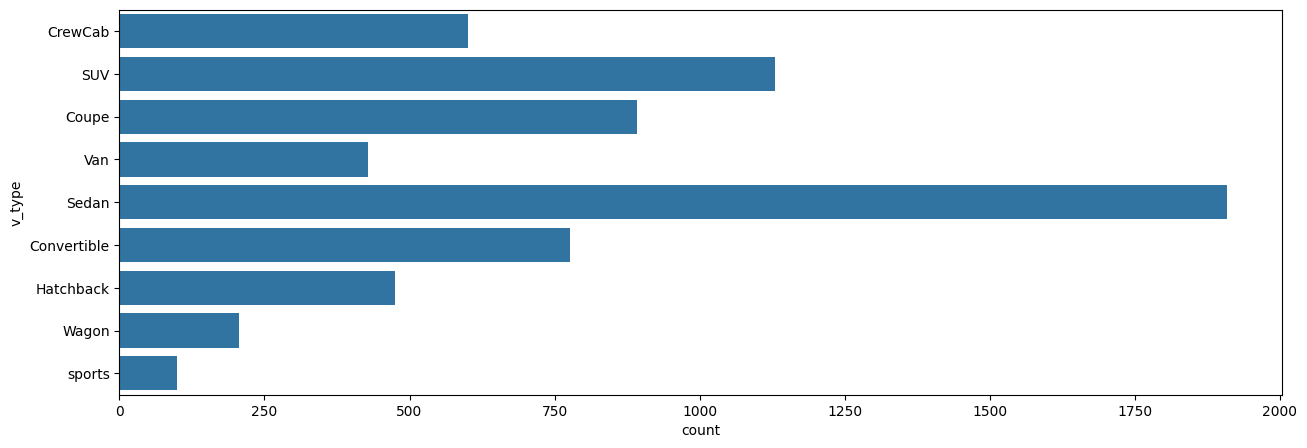

In [18]:
plt.figure(figsize=(15,5))
sns.countplot(y = 'v_type',data = train_data_met)

In [ ]:

#creating a new folder to store cropped car images
os.mkdir('stanford car data/new_data')
for new_classes in new_classes:
    os.mkdir('stanford car data/new_data/' + new_classes)

In [22]:
print('Created {} folders to store cropped images of the different types.'.format(len(os.listdir('stanford car data/new_data'))))

Created 9 folders to store cropped images of the different types.


In [24]:
train_data_met.head(1)

,TYPE,TRAIN_PATH,ORG_PATH,BBOX_X1,BBOX_X2,BBOX_Y1,BBOX_Y2,LABEL,IMAGE,v_type
0,TRAIN,stanford car data/cars_train/cars_train/,stanford car data/cars_train/cars_train/02443.jpg,74,62.0,617.0,411.0,HUMMER H3T Crew Cab 2010,02443.jpg,CrewCab


In [27]:
for i in range(0,6516):
    a =train_data_met['ORG_PATH'][i]
    xmin = int(train_data_met['BBOX_X1'][i]) 
    ymin = int(train_data_met['BBOX_X2'][i])
    xmax = int(train_data_met['BBOX_Y1'][i])
    ymax = int(train_data_met['BBOX_Y2'][i])
    print(i,a,xmin,xmax,ymin,ymax)
    img = Image.open(a)
    img = img.crop((xmin, ymin, xmax, ymax))
    img = img.convert('RGB')
    img = img.resize((224, 224))
    filename = train_data_met['IMAGE'][i]
    img.save('stanford car data/new_data/' + train_data_met['v_type'][i] + '/'+filename)

0 stanford car data/cars_train/cars_train/02443.jpg 74 617 62 411
1 stanford car data/cars_train/cars_train/02444.jpg 70 737 60 541
2 stanford car data/cars_train/cars_train/02445.jpg 30 743 99 427
3 stanford car data/cars_train/cars_train/02446.jpg 60 839 126 578
4 stanford car data/cars_train/cars_train/02447.jpg 64 341 58 177
5 stanford car data/cars_train/cars_train/02448.jpg 3 1017 226 621
6 stanford car data/cars_train/cars_train/02449.jpg 61 595 150 378
7 stanford car data/cars_train/cars_train/02450.jpg 51 595 99 382
8 stanford car data/cars_train/cars_train/02451.jpg 29 269 11 159
9 stanford car data/cars_train/cars_train/02452.jpg 20 249 44 161
10 stanford car data/cars_train/cars_train/02453.jpg 24 450 61 306
11 stanford car data/cars_train/cars_train/02454.jpg 50 605 167 392
12 stanford car data/cars_train/cars_train/02455.jpg 79 563 97 353
13 stanford car data/cars_train/cars_train/02456.jpg 40 224 38 155
14 stanford car data/cars_train/cars_train/02457.jpg 126 885 227 551

In [36]:
train_directory = "stanford car data/new_data"
#Data Augmentation and train-val split
#keras_preprocessing.image  ImageDataGenerator is used to generate tensor of image with realtime data augmentation.
#rescale helps to reduce the parameter
#shear range determines the maximum extent to which an object or an image can be distorted along a particular axis.
#zoom range is the range of random zoom
sd_gen = ImageDataGenerator(
    rescale = 1./255,
    shear_range=0.1,
    zoom_range=0.1,
    height_shift_range=0.1,
    width_shift_range=0.1,
    rotation_range=10,
    horizontal_flip=True,
    validation_split=0.2,
)

In [37]:
#https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator#flow_from_directory
#Loading train data
train_gen = sd_gen.flow_from_directory(
    train_directory,
    target_size=(224,224),
    batch_size=32,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

#Loading val data
val_gen = sd_gen.flow_from_directory(
    train_directory,
    target_size=(224,224),
    batch_size=32,
    class_mode='categorical',
    subset='validation',
    shuffle=True
)

Found 5215 images belonging to 9 classes.
Found 1301 images belonging to 9 classes.


In [41]:
class_weights = class_weight.compute_class_weight(class_weight = 'balanced', classes = np.unique(train_gen.classes),y = train_gen.classes)

In [40]:
#class_weight=class_weights) 

array([0, 0, 0, ..., 8, 8, 8], dtype=int32)

Found 5215 images belonging to 9 classes.


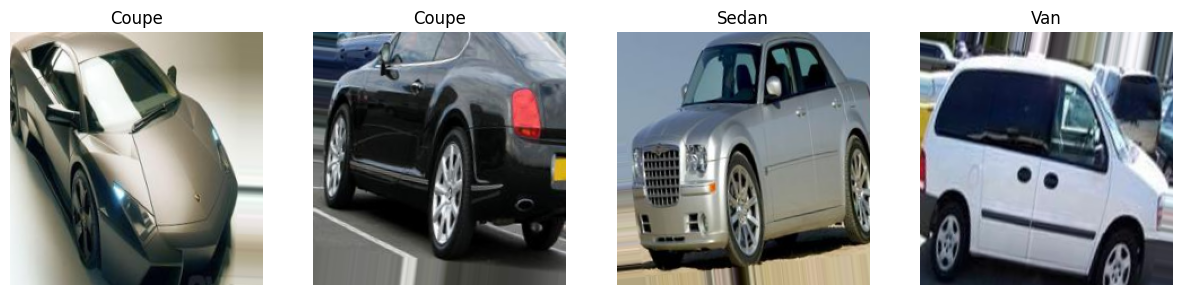

In [42]:
rand_gen = sd_gen.flow_from_directory(
    train_directory,
    target_size=(224,224),
    batch_size=1,
    class_mode='categorical',
    subset='training'
)

plt.figure(figsize=(15,10))
for i in range(4):
    rand_img = next(rand_gen)
    name = list(rand_gen.class_indices.keys())[list(rand_gen.class_indices.values()).index(np.argmax(rand_img[1]))]
    plt.subplot(1,4,i+1)
    plt.title(name)
    plt.imshow(rand_img[0].reshape(224, 224, 3))
    plt.axis('off')

In [43]:
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Dropout, Flatten, Dense, Activation, BatchNormalization
from keras.models import Sequential

In [ ]:
base_model_rsn0 = keras.applications.ResNet50V2(
    weights = 'imagenet',
    input_shape=(224, 224, 3),
    include_top=False)
x = keras.layers.Flatten()(base_model_rsn1.output)
x = keras.layers.Dropout(0.4)(x)
x = keras.layers.Dense(2048, activation='relu')(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Dropout(0.5)(x)
x = keras.layers.Dense(1024, activation='relu')(x) #half the dense
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Dropout(0.4)(x) #increased the drop out

out = keras.layers.Dense(196, activation='softmax')(x)

base_model_rsn1.trainable = False
for layer in base_model_rsn1.layers:
    layer.trainable = False

In [ ]:
for index, row in df.iterrows():
    # Access values of each column in the current row
    path = 'cars_test/'+row['image']
    # xmin = row['min_x']
    # ymin = row['min_y']
    # xmax = row['max_x']
    # ymax = row['max_y']
    # print(index,path,xmin,xmax,ymin,ymax)
    img = Image.open(path)
    # img = img.crop((xmin, ymin, xmax, ymax))
    img = img.convert('RGB')
    img = img.resize((224, 224))

    img.save('test_data/' + row['v_type'] + '/'+row['image'])

In [ ]:
model = keras.models.load_model('mobile150256lr=0.001dropout=0.4.tflite')

OSError: Unable to open file (file signature not found)

In [ ]:
val_directory = "test_data"

#Data Augmentation and train-val split
sd_gen = ImageDataGenerator(
    rescale = 1./255,
    validation_split=0.2
)

val_gen = sd_gen.flow_from_directory(
    val_directory,
    target_size=(224,224),
    batch_size=64,
    class_mode='categorical',
    subset='validation',
    shuffle=True
)

Found 1606 images belonging to 9 classes.


In [ ]:
loss, acc = model.evaluate(val_gen)
print(f"val_loss: {loss}, val_acc:{round(acc*100,2)}%")

26/26 [==============================] - 21s 797ms/step - loss: 0.9702 - accuracy: 0.6501
val_loss: 0.970164954662323, val_acc:65.01%


In [ ]:
import tensorflow as tf

# Load the TFLite model
interpreter = tf.lite.Interpreter(model_path='mobile150256lr=0.001dropout=0.4.tflite')
interpreter.allocate_tensors()
print('0')
# Get input and output details
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()
print('00')
# Prepare the test data (replace with your own data preprocessing code)
test_data = val_gen
print('1')
# Set the input tensor with the test data
interpreter.set_tensor(input_details[0]['index'], test_data)
print('101')
# Run the inference
interpreter.invoke()
print('12')
# Get the output tensor
output_data = interpreter.get_tensor(output_details[0]['index'])

# Interpret the output data (replace with your own post-processing code)
# For example, if it's a classification problem:
predicted_labels = tf.argmax(output_data, axis=1)
print('123')
# Print the predicted labels
print(predicted_labels)


0
00
1


ValueError: Failed to convert value into readable tensor.

In [ ]:
import numpy as np
import tensorflow as tf
from PIL import Image

# Load the TFLite model
interpreter = tf.lite.Interpreter(model_path='mobile150256lr=0.001dropout=0.4.tflite')
interpreter.allocate_tensors()

# Get input and output details
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Load and preprocess the test image
image_path = "test_data/Convertible/00002.jpg"
image = Image.open(image_path)
image = image.resize((input_details[0]['shape'][1], input_details[0]['shape'][2]))  # Resize to match input shape
image = np.expand_dims(image, axis=0)  # Add batch dimension if needed
image = image.astype(np.float32)  # Ensure data type matches the model

# Set the input tensor
interpreter.set_tensor(input_details[0]['index'], image)

# Run the inference
interpreter.invoke()

# Get the output tensor
output = interpreter.get_tensor(output_details[0]['index'])

# Process and interpret the output as needed
# ...

# Display or use the output predictions as required


In [ ]:
output

array([[1.0867420e-02, 1.6015759e-01, 1.2397942e-04, 5.5745488e-01,
        1.2878840e-02, 2.5468937e-01, 7.1126851e-05, 1.6517866e-03,
        2.1049716e-03]], dtype=float32)

In [ ]:
labels = model.labels

AttributeError: 'Functional' object has no attribute 'labels'

In [ ]:
model = keras.models.load_model('mobile150.model')